---
title: Match results exploratory data analysis
description: dkdzaod
kernelspec:
  name: TER
mystnb:
    execution_mode: 'cache'
---

### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import display, Markdown, HTML
from datetime import datetime

sns.set_theme(style = 'ticks', palette = 'pastel')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.bbox'] = 'tight'
sns.set_context("paper")
# Define fig saving context
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.directory'] = 'figures'


from utils.utils import filter_team, league_team, team_league, unique_teams, unique_teams_coach_change
# league_team : league -> [team]
# team_league : team -> league
# unique_teams : [all teams]
# unique_teams_coach_change : [all teams that have had a coach change]

### Loading data

In [2]:
match_results = pd.read_csv('data/match_results.csv', parse_dates=['date'])
# head_coach = pd.read_csv('data/head_coach.csv', parse_dates=['appointed', 'end_date'])

match_results.head()

,league,country,season_year,date,home_team,home_goals,away_team,away_goals
0,Premier League,England,2018,2017-08-11,Arsenal,4.0,Leicester City,3.0
1,Premier League,England,2018,2017-08-12,Watford,3.0,Liverpool,3.0
2,Premier League,England,2018,2017-08-12,Crystal Palace,0.0,Huddersfield,3.0
3,Premier League,England,2018,2017-08-12,West Brom,1.0,Bournemouth,0.0
4,Premier League,England,2018,2017-08-12,Chelsea,2.0,Burnley,3.0


In [3]:
# General information
min_year = match_results['date'].min()
max_year = match_results['date'].max()

### General information about data

Data collected from match results ranges from {eval}`min_year.strftime("%m/%d/%Y")` to {eval}`max_year.strftime("%m/%d/%Y")` and contains the results of {eval}`len(match_results)` matches.

Matches have been collected for the following leagues : **{eval}`", ".join(match_results['league'].unique().tolist())`**

In [4]:
# Leagues informations
match_results['total_goals'] = match_results['home_goals'] + match_results['away_goals']
leagues = (match_results.groupby(['league', 'country'])
            .agg(matches_played=('home_team', 'count'), avg_goals=('total_goals', 'mean'))
            .reset_index()
            .assign(league_country=lambda df: df['league'] + ' (' + df['country'] + ')')
            .sort_values(by='matches_played', ascending=False))
# Number of teams : use league_team = {league: [team]} to get the number of teams in each league and add it to league dataframe
leagues['number_of_teams'] = leagues['league'].apply(lambda x: len(league_team[x]))

league_team_coach_change = {league: [team for team in league_team[league] if team in unique_teams_coach_change] for league in league_team}
leagues['number_of_teams_with_coach_change'] = leagues['league'].apply(lambda x: len(league_team_coach_change[x]))
# Round avg goals
leagues['avg_goals'] = leagues['avg_goals'].round(2)
# Drop league and country columns
leagues = leagues.drop(columns=['league', 'country'])
leagues = leagues.set_index('league_country')
# Rename columns with proper formatting
leagues = leagues.rename(columns={'matches_played': 'Number of match played', 'avg_goals': 'Average goals', 'number_of_teams': 'Number of teams', 'number_of_teams_with_coach_change': 'Number of teams with coach change'})
# Reorder columns
leagues = leagues[['Number of match played', 'Average goals', 'Number of teams', 'Number of teams with coach change']]
# Rename index
leagues.index.name = 'Leagues'
display(HTML(leagues.to_html()))

,Number of match played,Average goals,Number of teams,Number of teams with coach change
Leagues,,,,
Ligue 1 (France),1908,2.68,28,12
La Liga (Spain),1900,2.55,28,14
Premier League (England),1900,2.75,28,15
Serie A (Italy),1900,2.86,28,16
Bundesliga (Germany),1540,3.06,27,13


In [5]:
for team in unique_teams:
    if filter_team(team).shape[0] != filter_team(team).drop_duplicates().shape[0]:
        print(f"Team {team} has more than one match in the same day")
# No team played more than one match in the same day (ie. (date, team) can be index of match_result)

### Basic plots

In [6]:
# Useful to add xtick months to dayofyear plot
months = pd.date_range('2022-01-01', '2022-12-31', freq='ME').strftime('%b').tolist()
days = np.linspace(1, 365, num=12, dtype=int)

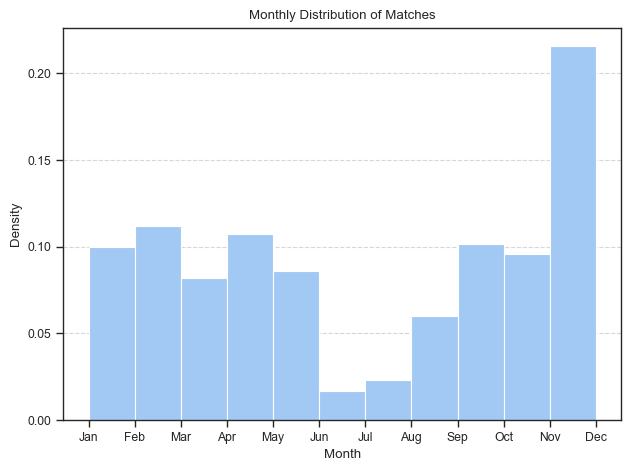

In [7]:
# Plot distribution of match 
plt.figure()
plt.hist(match_results['date'].dt.month, bins=11, color = 'b', density=True)
plt.title('Monthly Distribution of Matches')
plt.xlabel('Month')
plt.ylabel('Density')
plt.xticks(range(1, 13), months)
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.savefig('figures/match_distribution.png')

In [8]:
match_results.head()

,league,country,season_year,date,home_team,home_goals,away_team,away_goals,total_goals
0,Premier League,England,2018,2017-08-11,Arsenal,4.0,Leicester City,3.0,7.0
1,Premier League,England,2018,2017-08-12,Watford,3.0,Liverpool,3.0,6.0
2,Premier League,England,2018,2017-08-12,Crystal Palace,0.0,Huddersfield,3.0,3.0
3,Premier League,England,2018,2017-08-12,West Brom,1.0,Bournemouth,0.0,1.0
4,Premier League,England,2018,2017-08-12,Chelsea,2.0,Burnley,3.0,5.0


In [9]:
total_matches = match_results.shape[0]
home_goals = match_results['home_goals'].mean()
away_goals = match_results['away_goals'].mean()
diff_goal_perc = ((home_goals - away_goals) / away_goals) * 100

home_win = (match_results['home_goals'] > match_results['away_goals']).sum()
away_win = (match_results['home_goals'] < match_results['away_goals']).sum()
diff_win_perc = ((home_win - away_win) / away_win) * 100

draw_count = (match_results['home_goals'] == match_results['away_goals']).sum()
draw_perc = (draw_count / (home_win + away_win)) * 100

{eval}`f"In average, team playing at home scored {home_goals:.2f} goals while away team scored {away_goals:.2f} goals ({+ diff_goal_perc:.0f} % more goals)."`

{eval}`f"This resulted in {home_win} matches won by team playing at home vs {away_win} for the team playing away ({diff_win_perc:.0f} % more wins)"`

{eval}`f"{draw_count} matches resulted in a draw ({draw_perc:.0f} %)"`

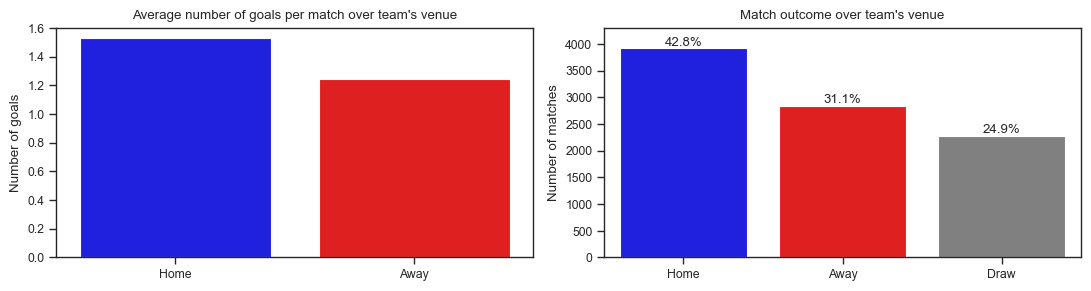

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(11, 3))

sns.barplot(x=['Home', 'Away'], y=[home_goals, away_goals], ax=ax[0], palette=['blue', 'red'], hue = ['Home', 'Away'])
ax[0].set_title('Average number of goals per match over team\'s venue')
ax[0].set_ylabel('Number of goals')

sns.barplot(x=['Home', 'Away', 'Draw'], y=[home_win, away_win, draw_count], ax=ax[1], palette=['blue', 'red', 'grey'], hue = ['Home', 'Away', 'Draw'])
ax[1].set_title('Match outcome over team\'s venue')
ax[1].set_ylabel('Number of matches')
# Set y limit a bit higher
ax[1].set_ylim(0, home_win * 1.1)

# Add percentage of total match
for p in ax[1].patches:
    percentage = f'{100 * p.get_height() / total_matches:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax[1].text(x, y, percentage, ha='center', va='bottom')

plt.savefig('figures/venue_effect.png')